In [1]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Positive, Interval

from alfi.models import OrdinaryLFM, MultiOutputGP #MLPLFM
from alfi.utilities.torch import inv_softplus, softplus
from alfi.datasets import DeterministicLotkaVolterra
from alfi.plot import Plotter1d, plot_phase, Colours
from alfi.configuration import VariationalConfiguration
from alfi.trainers import VariationalTrainer

import os 
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

from data import PVDataGenerator, PV_LFM_Dataset
from data.utils import *
from data.lfm_dataset import PV_LFM_Dataset
from models.approximate_lfm import LotkaVolterra, MultiOutputGP

f64 = np.float64

/Users/eirikbaekkelund/opt/anaconda3/envs/lfm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: typing.Optional requires a single type. Got <module 'gpytorch.constraints' from '/Users/eirikbaekkelund/opt/anaconda3/envs/lfm/lib/python3.9/sit.

In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 2
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

num_outputs = 1
num_latents = 1
num_inducing = 100

In [19]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = generator.get_time_series()
interval = 2

X, y = X[::interval], y[::interval]

x_train, y_train, x_test, y_test = train_test_split(X, y, n_hours=N_HOURS_PRED)

x_train[:,1] *= y_train[:,:num_outputs].max()
x_test[:,1] *= y_test[:,:num_outputs].max()

==> Loading data
==> Loaded data in: 0 m : 6 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([72, 2]),
 torch.Size([72, 15]),
 torch.Size([24, 2]),
 torch.Size([24, 15]))

In [21]:
t_train = torch.linspace(0, 10, len(y_train))

In [46]:
dataset = PV_LFM_Dataset(num_outputs=num_outputs, 
                         m_observed=y_train[:, 3:4],
                         f_observed=y_train[:,2], 
                         train_t=t_train,
                         variance= 0.01 * torch.ones(num_outputs, dtype=torch.float64))

In [47]:
x_min, x_max = dataset.t_observed.min(), dataset.t_observed.max()
num_training = len(dataset.t_observed)

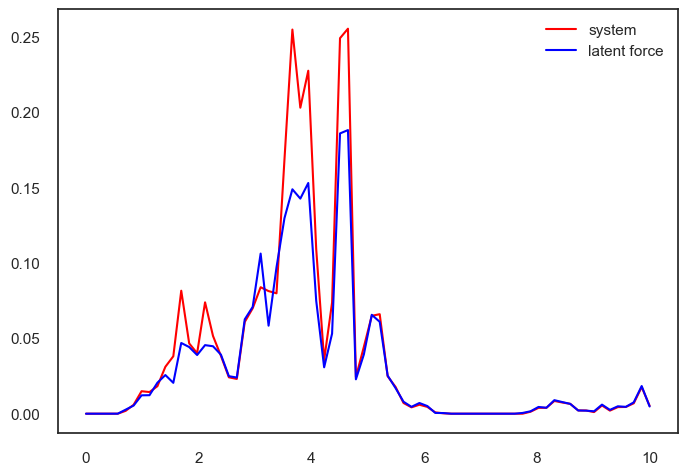

In [48]:
plt.rcParams['font.family'] = 'Arial'

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='system')
plt.plot(torch.linspace(x_min, x_max, dataset.f_observed.shape[0]), dataset.f_observed, c='blue', label='latent force')
plt.legend()
output_names = dataset.names

In [49]:
from gpytorch.constraints import Positive, Interval
from torch.nn import Parameter
from alfi.utilities.torch import softplus, inv_softplus

class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 100)
        self.raw_decay = Parameter(self.decay_constraint.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        print(dataset.f_observed.shape)
        self.true_f = dataset.f_observed[::1].unsqueeze(0).repeat(self.config.num_samples, 1).unsqueeze(1)
        print(self.true_f.shape)
        
    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):

        self.nfe += 1

        f = self.f[:, :, self.t_index].unsqueeze(2)
        dh = self.growth_rate * h * f - self.decay_rate * h

        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
    
        return dh

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)

tensor([[[0.6931]]], grad_fn=<SoftplusBackward>)
torch.Size([72])
torch.Size([70, 1, 72])


/Users/eirikbaekkelund/opt/anaconda3/envs/lfm/lib/python3.9/site-packages/alfi/models/variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


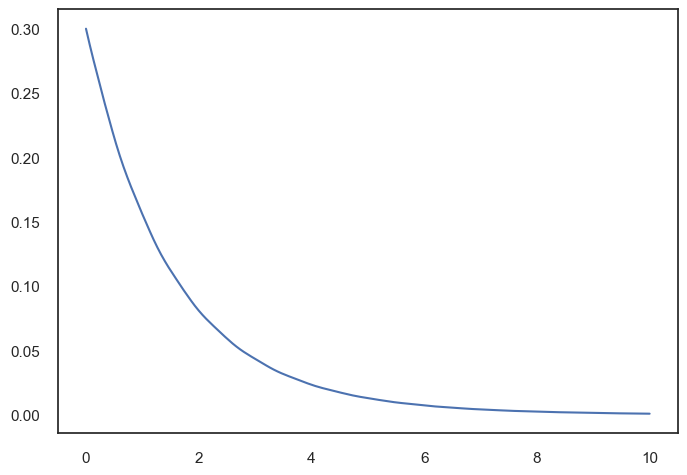

In [50]:
config = VariationalConfiguration(num_samples=70)
inducing_points = torch.linspace(x_min, x_max, num_inducing).repeat(num_latents, 1).view(
    num_latents, num_inducing, 1)
    
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
with torch.no_grad():
    mean_module.constant -= 0.2
track_parameters = ['raw_growth', 'raw_decay']


covar_module = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
        batch_shape=torch.Size([num_latents])
    ) 
print(covar_module.base_kernel.period_length)

track_parameters.append('gp_model.covar_module.base_kernel.raw_lengthscale')
track_parameters.append('gp_model.covar_module.base_kernel.raw_period_length')

gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, num_latents,
                         natural=False)

lfm = LotkaVolterra(num_outputs, gp_model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))
plt.rcParams['font.family'] = 'Arial'

out = lfm(t_predict, step_size=1e-2)
plt.plot(t_predict, out.mean.detach())

In [51]:
optimizers = [torch.optim.Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizers,
    dataset,
    warm_variational=100,
    track_parameters=track_parameters
)

In [52]:
a = trainer.train(500, report_interval=10, step_size=0.1)

/Users/eirikbaekkelund/opt/anaconda3/envs/lfm/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: For batch 0: U(27,27) is zero, singular U.. Using RootDecomposition.
  warnings.warn(


Epoch 001/500 - Loss: 1.09 (1.09 0.00) kernel: [nan]


NanError: cholesky_cpu: 10000 of 10000 elements of the torch.Size([1, 100, 100]) tensor are NaN.

f obs torch.Size([24])


AttributeError: 'PV_LFM_Dataset' object has no attribute 'prey'

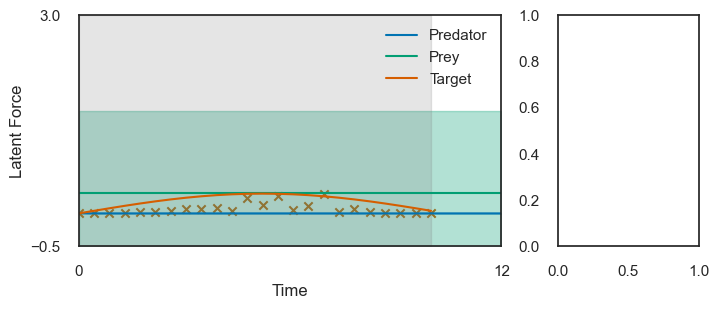

In [17]:
lfm.eval()
t_interval = (0, 12)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=1e-2)
q_f = lfm.predict_f(t_predict)
ylim = (-0.5, 3)
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PV power')

axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])

print('f obs', dataset.f_observed.shape)

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Latent Force')
axes[0].plot(dataset.times, dataset.f_observed, c=Colours.scatter_color, label='Target')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred,
           ax=axes[1])
axes[1].set_xlabel('Prey population')
axes[1].set_ylabel('Predator population')
axes[1].set_yticks([0, 1])
plt.tight_layout()
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
plt.savefig('./periodic-combined.pdf', **tight_kwargs)


In [41]:
import numpy as np

def total_grade_score(
    bdl : float = 0.76,
    aml : float = 0.95,
    alg : float = 0.78,
    amlf : float = 0.79,
    adl : float = 0.84,
    iml : float = 0.55,
    pm : float = 0.5,
    stats : float = 0.67,
    diss : float = 0.65,
    w_classes : float = 2/(3*8),
    w_thesis :float = 1/3):
    """
    Calculates the total grade score for a student.
    """
    grades = bdl + aml + alg + amlf + adl + iml + pm + stats + diss
    weighted_grades = grades * w_classes 
    weighted_thesis = diss * w_thesis
    return weighted_grades + weighted_thesis

In [42]:
total_grade_score()

0.7575